In [ ]:
!nvidia-smi

Tue Sep  7 14:04:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     Off  | 00000000:1B:00.0 Off |                  Off |
| 33%   31C    P8     8W / 230W |      0MiB / 16125MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
## importing libraries
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

In [ ]:
## Setting the random seed so that the results don't vary drastically
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In [ ]:
## path declerations
## each sequence contains 30 images
## train_doc: list of path of all the training videos
## val_doc: list of path of all the validation videos
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 10 #experiment with the batch size

## ## Generator
This is one of the most important part of the code. In the generator, we are going to preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames. We will experiment with `img_idx`, `y`,`z` and normalization such that we get high accuracy.

- We can use this generator for texts as well as this is a very generic generator function. 
- Here we have tried to model the in-built Keras ImageDataGenerator through our custom genertor.

In [ ]:
## Defining Generator
x = 18 # number of frames
y = 120 # image width
z = 120 # image height

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,25,26,27,28,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    ## resixing the images
                    
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # The code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


# Model
Here we make the model using different functionalities that Keras provides. 
We will be using two approaches:
1. ConV3D model
2. ConV 2D plus RNN

## ConV 3D Models

## Base Conv 3D
### Approach:
- First we will make a big model and feed it with samll data to make sure thart the model overfits the data. Overfitting will ensure that the model is free of 'silent errors'
- Once we know that the model is ok, then we will start experimenting with the model.
- We will first trey to lessen the model parameters
- For the experiments we will use the ablation approach that is before we train the full model, we will take a small chunk of the data and check whether our model is working on it.
- The idea is simple, we  will take a small chunk of the dataset and try doing a lot of experiments on it in a very limited number of epochs
- If the mode seems promising then we will train it on full data and more epochs
- Since we are going to be conducting a lot of experiments, and given the limited amount of memory space, GPU resources and time, we will save only the best model parameters during training
- This will save the training time as well as GPU resources and memory

In [ ]:
## imporitng libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

# Code for the base model
# base_model
base_model = Sequential()

base_model.add(Conv3D(32, #number of filters 
                 kernel_size=(3,3,3), 
                 input_shape=(18, 120, 120, 3),
                 padding='same'))
base_model.add(BatchNormalization())
base_model.add(Activation('relu'))

base_model.add(MaxPooling3D(pool_size=(2,2,2)))

base_model.add(Conv3D(64, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
base_model.add(BatchNormalization())
base_model.add(Activation('relu'))

base_model.add(MaxPooling3D(pool_size=(2,2,2)))

base_model.add(Conv3D(128, #Number of filters 
                 kernel_size=(1,3,3), 
                 padding='same'))
base_model.add(BatchNormalization())
base_model.add(Activation('relu'))

base_model.add(MaxPooling3D(pool_size=(2,2,2)))

base_model.add(Conv3D(256, #Number pf filters 
                 kernel_size=(1,3,3), 
                 padding='same'))
base_model.add(BatchNormalization())
base_model.add(Activation('relu'))

base_model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
base_model.add(Flatten())

base_model.add(Dense(1000, activation='relu'))
base_model.add(Dropout(0.5))

base_model.add(Dense(500, activation='relu'))
base_model.add(Dropout(0.5))

#softmax layer
base_model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
base_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (base_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 18, 120, 120, 32)  2624      
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 120, 120, 32)  128       
_________________________________________________________________
activation (Activation)      (None, 18, 120, 120, 32)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 9, 60, 60, 32)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 9, 60, 60, 64)     55360     
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 60, 60, 64)     256       
_________________________________________________________________
activation_1 (Activation)    (None, 9, 60, 60, 64)     0

In [ ]:
## feeding 100 images each from the training and the validation sets
train_generator = generator(train_path, train_doc[0:99], batch_size)
val_generator = generator(val_path, val_doc[0:99], batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = base_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 12.8033 - categorical_accuracy: 0.3137Source path =  /home/datasets/Project_data/val ; batch size = 10
Batch:  10 Index: 10

Epoch 00001: val_loss improved from inf to 2.21642, saving model to model_init_2021-09-0707_15_30.700371/model-00001-12.80326-0.31373-2.21642-0.24242.h5
67/67 [==============================] - 82s 1s/step - loss: 12.8033 - categorical_accuracy: 0.3137 - val_loss: 2.2164 - val_categorical_accuracy: 0.2424
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 1.4771 - categorical_accuracy: 0.5456
Epoch 00002: val_loss improved from 2.21642 to 1.64573, saving model to model_init_2021-09-0707_15_30.700371/model-00002-1.47705-0.54561-1.64573-0.22222.h5
67/67 [==============================] - 79s 1s/step - loss: 1.4771 - categorical_accuracy: 0.5

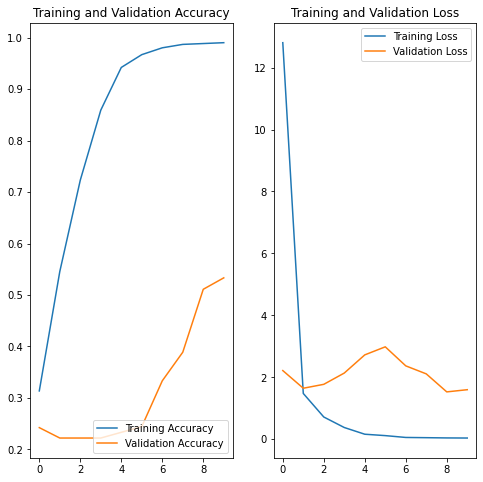

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- So, we can see that the big model overfits on small data, hence the model is free of `silent errors' and we can say that the model works.
- Now let's conduct some experiments on the model again using the ablation framework, i.e., conducting experiments on the models using small samples of data. 

## Experiment 1 : model_1
- Ablation approach
- cropping the image
- Feeding all the 30 Frames

In [ ]:
## Genearator
x = 30 # number of frames
y = 120 # image width
z = 120 # image height
##  Feeding all the 30 Frames
img_idx = [ x for x in range(0,30)]

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [ x for x in range(0,30)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    ## cropping the image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,10:150]
                    else:
                        pass
                    ## resizing image  
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    ## cropping the image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,10:150]
                    else:
                        pass
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [ ]:
## Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here

model_1 = Sequential()

model_1.add(Conv3D(32,kernel_size=(3,3,3),
                 input_shape=(30, 120, 120, 3),
                 padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))

model_1.add(MaxPooling3D(pool_size=(2,2,2)))

model_1.add(Conv3D(64,kernel_size=(3,3,3), 
                 padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))

model_1.add(MaxPooling3D(pool_size=(2,2,2)))

model_1.add(Conv3D(128,kernel_size=(1,3,3), 
                 padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))

model_1.add(MaxPooling3D(pool_size=(2,2,2)))

model_1.add(Conv3D(256,kernel_size=(1,3,3), 
                 padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))

model_1.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_1.add(Flatten())

model_1.add(Dense(1000, activation='relu'))
model_1.add(Dropout(0.5))

model_1.add(Dense(500, activation='relu'))
model_1.add(Dropout(0.5))

#softmax layer
model_1.add(Dense(5, activation='softmax'))

In [ ]:
## setting optimizer and compiling the model
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 30, 120, 120, 32)  2624      
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 120, 120, 32)  128       
_________________________________________________________________
activation_4 (Activation)    (None, 30, 120, 120, 32)  0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 15, 60, 60, 32)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 15, 60, 60, 64)    55360     
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 60, 60, 64)    256       
_________________________________________________________________
activation_5 (Activation)    (None, 15, 60, 60, 64)   

In [ ]:
## picking 200 images each from training and validtion sets
train_generator = generator(train_path, train_doc[0:199], batch_size)
val_generator = generator(val_path, val_doc[0:199], batch_size)


In [ ]:
## saving model name after each epoch
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
### the learning rate after each epoch into the disk with the filepath name
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 17.4265 - categorical_accuracy: 0.2773Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 11.11796, saving model to model_init_2021-09-0707_29_45.206282/model-00001-17.42653-0.27725-11.11796-0.22000.h5
67/67 [==============================] - 98s 1s/step - loss: 17.4265 - categorical_accuracy: 0.2773 - val_loss: 11.1180 - val_categorical_accuracy: 0.2200
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 9.6328 - categorical_accuracy: 0.1791
Epoch 00002: val_loss improved from 11.11796 to 1.82839, saving model to model_init_2021-09-0707_29_45.206282/model-00002-9.63279-0.17910-1.82839-0.25000.h5
67/67 [==============================] - 35s 527ms/step - loss: 9.6328 - categorical_accuracy: 0.1791 - val_loss: 1.8284 - val_categorical_accuracy: 0.2500
Epoch 3/20
67/67 [==============

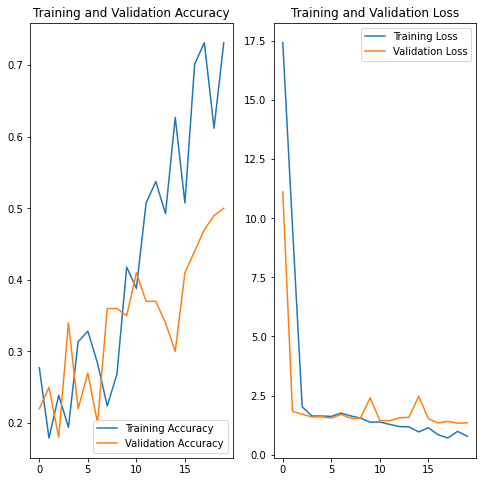

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Experiment 2 : model_2
- Abaltion appproach
- Using early stopping 
- Feeding 20 frames
- Making model leaner and feeding more data ( 200 images each from the training and validation sets)
- Cropping the images

In [ ]:
## Genearator
x = 20  # number of frames
y = 120 # image width
z = 120 # image height
batch_size = 10
img_idx = [0,1,2,3,4,6,8,10,12,14,16,18,20,21,22,24,25,26,28,29]

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,3,4,6,8,10,12,14,16,18,20,21,22,24,25,26,28,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    ## cropping the image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,10:150]
                    else:
                        pass
                    ## resizing image  
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    ## normalising the image
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    ## cropping the image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,10:150]
                    else:
                        pass
                    ## resizing the image
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    ## normalising the image
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [ ]:
## Leaner Model ( halving the parameters)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here
# model_2
model_2 = Sequential()

model_2.add(Conv3D(16,kernel_size=(3,3,3), 
                 input_shape=(20, 120, 120, 3),
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))

model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(32,kernel_size=(3,3,3), 
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))

model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(64,kernel_size=(1,3,3), 
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))

model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(128,kernel_size=(1,3,3), 
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))

model_2.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_2.add(Flatten())

model_2.add(Dense(500, activation='relu'))
model_2.add(Dropout(0.5))

model_2.add(Dense(250, activation='relu'))
model_2.add(Dropout(0.5))

#softmax layer
model_2.add(Dense(5, activation='softmax'))

In [ ]:
## setting optimizer and compiling the model
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_8 (Batch (None, 20, 120, 120, 16)  64        
_________________________________________________________________
activation_8 (Activation)    (None, 20, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_9 (Batch (None, 10, 60, 60, 32)    128       
_________________________________________________________________
activation_9 (Activation)    (None, 10, 60, 60, 32)   

In [ ]:
## ablation apporach: feeding 200 images each from the training and the validation sets
train_generator = generator(train_path, train_doc[0:199], batch_size)
val_generator = generator(val_path, val_doc[0:199], batch_size)

In [ ]:
## saving model name after each epoch
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
### the learning rate after each epoch into the disk with the filepath name
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
## using earlystop
earlystop = tf.keras.callbacks.EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 7.4980 - categorical_accuracy: 0.2867Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 3.00658, saving model to model_init_2021-09-0707_43_37.373474/model-00001-7.49804-0.28673-3.00658-0.26000.h5
67/67 [==============================] - 65s 976ms/step - loss: 7.4980 - categorical_accuracy: 0.2867 - val_loss: 3.0066 - val_categorical_accuracy: 0.2600
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 6.0206 - categorical_accuracy: 0.2239
Epoch 00002: val_loss improved from 3.00658 to 2.26943, saving model to model_init_2021-09-0707_43_37.373474/model-00002-6.02057-0.22388-2.26943-0.19000.h5
67/67 [==============================] - 25s 374ms/step - loss: 6.0206 - categorical_accuracy: 0.2239 - val_loss: 2.2694 - val_categorical_accuracy: 0.1900
Epoch 3/20
67/67 [==================

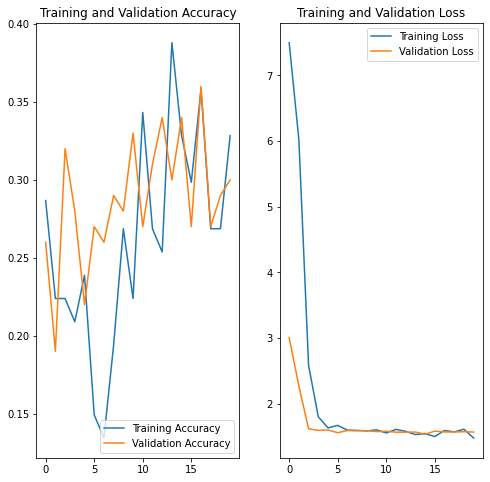

In [ ]:
## plotting the model fit 
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Experiment 3 : model_3
- Ablation approach
- Reducing the number of frames
- Increasing the number of fully conected layers

In [ ]:
## Genearator
x = 16  # number of frames
y = 120 # image width
z = 120 # image height
batch_size = 10

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    ## cropping the image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,10:150]
                    else:
                        pass
                    ## resizing image  
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    ## normalising the image
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    ## cropping the image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,10:150]
                    else:
                        pass
                    ## resizing the image
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    ## normalising the image
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [ ]:
## Leaner Model ( halving the parameters)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here
# model_3
model_3 = Sequential()

model_3.add(Conv3D(16,kernel_size=(3,3,3), 
                 input_shape=(16, 120, 120, 3),
                 padding='same'))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))

model_3.add(MaxPooling3D(pool_size=(2,2,2)))

model_3.add(Conv3D(32,kernel_size=(3,3,3), 
                 padding='same'))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))

model_3.add(MaxPooling3D(pool_size=(2,2,2)))

model_3.add(Conv3D(64,kernel_size=(1,3,3), 
                 padding='same'))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))

model_3.add(MaxPooling3D(pool_size=(2,2,2)))

model_3.add(Conv3D(128,kernel_size=(1,3,3), 
                 padding='same'))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))

model_3.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_3.add(Flatten())

model_3.add(Dense(1000, activation='relu'))
model_3.add(Dropout(0.5))

model_3.add(Dense(500, activation='relu'))
model_3.add(Dropout(0.5))

#softmax layer
model_3.add(Dense(5, activation='softmax'))

In [ ]:
## setting optimizer and compiling the model
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_3.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_12 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
activation_12 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
batch_normalization_13 (Batc (None, 8, 60, 60, 32)     128       
_________________________________________________________________
activation_13 (Activation)   (None, 8, 60, 60, 32)    

In [ ]:
## picking 200 images each from training and validtion sets
train_generator = generator(train_path, train_doc[0:199], batch_size)
val_generator = generator(val_path, val_doc[0:199], batch_size)

In [ ]:
## saving model name after each epoch
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
### the learning rate after each epoch into the disk with the filepath name
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
## using earlystop
earlystop = tf.keras.callbacks.EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

In [ ]:
## training the model
history = model_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 10.6790 - categorical_accuracy: 0.3009Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 3.19951, saving model to model_init_2021-09-0707_54_13.453347/model-00001-10.67897-0.30095-3.19951-0.30000.h5
67/67 [==============================] - 56s 836ms/step - loss: 10.6790 - categorical_accuracy: 0.3009 - val_loss: 3.1995 - val_categorical_accuracy: 0.3000
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 5.6103 - categorical_accuracy: 0.2090
Epoch 00002: val_loss improved from 3.19951 to 1.64365, saving model to model_init_2021-09-0707_54_13.453347/model-00002-5.61025-0.20896-1.64365-0.21000.h5
67/67 [==============================] - 20s 295ms/step - loss: 5.6103 - categorical_accuracy: 0.2090 - val_loss: 1.6437 - val_categorical_accuracy: 0.2100
Epoch 3/20
67/67 [===============

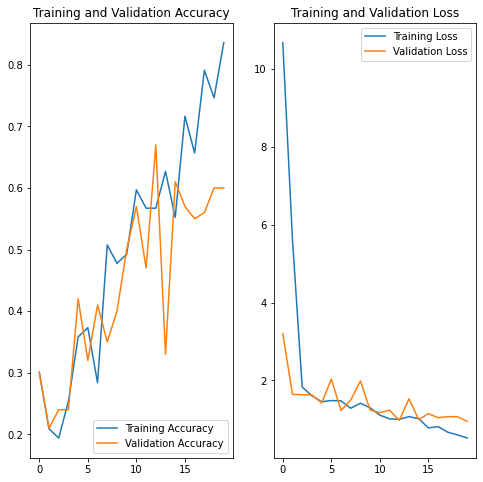

In [ ]:
## plotting the model fit
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- The model seems to be working fine
- Let's try feeding more data to see it's performance

### Feeding full data to model 3

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


In [ ]:
## full data
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
# training the model
history = model_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 0.9898 - categorical_accuracy: 0.6290Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss did not improve from 0.94913
67/67 [==============================] - 75s 1s/step - loss: 0.9898 - categorical_accuracy: 0.6290 - val_loss: 1.0133 - val_categorical_accuracy: 0.6200
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 0.9299 - categorical_accuracy: 0.6169
Epoch 00002: val_loss did not improve from 0.94913
67/67 [==============================] - 30s 453ms/step - loss: 0.9299 - categorical_accuracy: 0.6169 - val_loss: 0.9638 - val_categorical_accuracy: 0.6600
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 0.8962 - categorical_accuracy: 0.6716
Epoch 00003: val_loss did not improve from 0.94913
67/67 [==============================] - 32s 474ms/step - loss: 0.8962 - categorical_acc

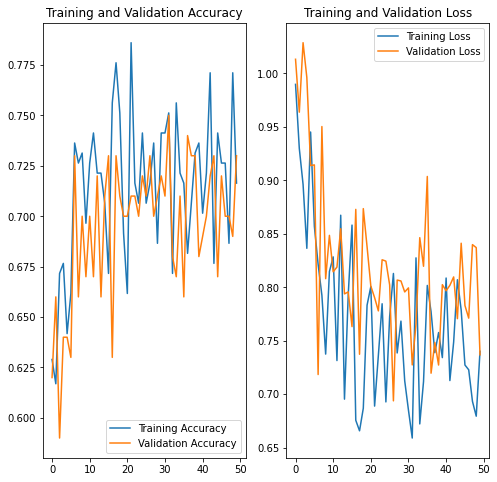

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- This model is somewhat acceptable as it is not overfitting
- Let's further make changes to see if we can get the accuracy up while also ensuring that the model does not overfit or underfit

## Experiment 4 : model_4
- ablation approach
- reducing model parameters
- reducing image size
- changing cropping

In [ ]:
## Genearator
x = 16  # number of frames
y = 100 # image width
z = 100 # image height
batch_size= 10


def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,27,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    ## cropping the image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:100,10:120]
                    else:
                        pass
                    ## resizing image  
                    resized_image = resize(image,(100,100)).astype(np.float32)
                    ## normalising the image
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    ## cropping the image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:100,10:120]
                    else:
                        pass
                    ## resizing the image
                    resized_image = resize(image,(100,100)).astype(np.float32)
                    ## normalising the image
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [ ]:
## Leaner Model ( reducing the parameters)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here
# model_4
model_4 = Sequential()

model_4.add(Conv3D(8,kernel_size=(3,3,3), 
                 input_shape=(16, 100, 100, 3),
                 padding='same'))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))

model_4.add(MaxPooling3D(pool_size=(2,2,2)))

model_4.add(Conv3D(16,kernel_size=(3,3,3), 
                 padding='same'))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))

model_4.add(MaxPooling3D(pool_size=(2,2,2)))

model_4.add(Conv3D(32,kernel_size=(1,3,3), 
                 padding='same'))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))

model_4.add(MaxPooling3D(pool_size=(2,2,2)))

model_4.add(Conv3D(64,kernel_size=(1,3,3), 
                 padding='same'))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))

model_4.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_4.add(Flatten())

model_4.add(Dense(1000, activation='relu'))
model_4.add(Dropout(0.5))

model_4.add(Dense(500, activation='relu'))
model_4.add(Dropout(0.5))

#softmax layer
model_4.add(Dense(5, activation='softmax'))

In [ ]:
## setting optimizer and compiling the model
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_4.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 16, 100, 100, 8)   656       
_________________________________________________________________
batch_normalization_16 (Batc (None, 16, 100, 100, 8)   32        
_________________________________________________________________
activation_16 (Activation)   (None, 16, 100, 100, 8)   0         
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 8, 50, 50, 8)      0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 8, 50, 50, 16)     3472      
_________________________________________________________________
batch_normalization_17 (Batc (None, 8, 50, 50, 16)     64        
_________________________________________________________________
activation_17 (Activation)   (None, 8, 50, 50, 16)    

In [ ]:
## picking 200 images each from training and validtion sets
train_generator = generator(train_path, train_doc[0:199], batch_size)
val_generator = generator(val_path, val_doc[0:199], batch_size)

In [ ]:
## saving model name after each epoch
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
### the learning rate after each epoch into the disk with the filepath name
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
## using earlystop
earlystop = tf.keras.callbacks.EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
## training the model
history = model_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20
66/67 [============================>.] - ETA: 0s - loss: 4.7607 - categorical_accuracy: 0.2589Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2021-09-0708_29_31.721590/model-00001-4.76334-0.25829-3.97357-0.18000.h5
67/67 [==============================] - 51s 758ms/step - loss: 4.7633 - categorical_accuracy: 0.2583 - val_loss: 3.9736 - val_categorical_accuracy: 0.1800
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 4.5717 - categorical_accuracy: 0.2388
Epoch 00002: saving model to model_init_2021-09-0708_29_31.721590/model-00002-4.57170-0.23881-2.87917-0.24000.h5
67/67 [==============================] - 19s 284ms/step - loss: 4.5717 - categorical_accuracy: 0.2388 - val_loss: 2.8792 - val_categorical_accuracy: 0.2400
Epoch 3/20
66/67 [============================>.] - ETA: 0s - loss: 3.4103 - categorical_accuracy: 0.3182
Epoch 00003:

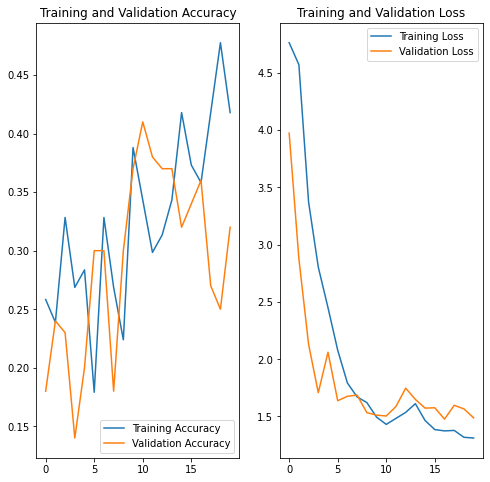

In [ ]:
# plotting the model fit
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Experiment 5 : model_5
- ablation approach
- increasing the batch size to 20
- image size 120,120
- leaner model dimensions

In [ ]:
## Genearator
x = 16  # number of frames
y = 120 # image width
z = 120 # image height
batch_size = 20

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    ## cropping the image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,10:150]
                    else:
                        pass
                    ## resizing image  
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    ## normalising the image
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    ## cropping the image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,10:150]
                    else:
                        pass
                    ## resizing the image
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    ## normalising the image
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [ ]:
## Leaner Model ( reducing the parameters)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

# model_5
model_5 = Sequential()

model_5.add(Conv3D(8,kernel_size=(3,3,3), 
                 input_shape=(16, 120, 120, 3),
                 padding='same'))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))

model_5.add(MaxPooling3D(pool_size=(2,2,2)))

model_5.add(Conv3D(16,kernel_size=(3,3,3), 
                 padding='same'))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))

model_5.add(MaxPooling3D(pool_size=(2,2,2)))

model_5.add(Conv3D(32,kernel_size=(1,3,3), 
                 padding='same'))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))

model_5.add(MaxPooling3D(pool_size=(2,2,2)))

model_5.add(Conv3D(64,kernel_size=(1,3,3), 
                 padding='same'))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))

model_5.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_5.add(Flatten())

model_5.add(Dense(1000, activation='relu'))
model_5.add(Dropout(0.5))

model_5.add(Dense(500, activation='relu'))
model_5.add(Dropout(0.5))

#softmax layer
model_5.add(Dense(5, activation='softmax'))

In [ ]:
## setting optimizer and compiling the model
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_5.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 16, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_20 (Batc (None, 16, 120, 120, 8)   32        
_________________________________________________________________
activation_20 (Activation)   (None, 16, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 8, 60, 60, 8)      0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 8, 60, 60, 16)     3472      
_________________________________________________________________
batch_normalization_21 (Batc (None, 8, 60, 60, 16)     64        
_________________________________________________________________
activation_21 (Activation)   (None, 8, 60, 60, 16)    

In [ ]:
## picking 200 images each from training and validtion sets
train_generator = generator(train_path, train_doc[0:199], batch_size)
val_generator = generator(val_path, val_doc[0:199], batch_size)

In [ ]:
## saving model name after each epoch
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
### the learning rate after each epoch into the disk with the filepath name
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
## using earlystop
earlystop = tf.keras.callbacks.EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
## training the model
history = model_5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 5.0424 - categorical_accuracy: 0.3029Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.84629, saving model to model_init_2021-09-0708_36_55.222385/model-00001-5.04239-0.30291-1.84629-0.16000.h5
34/34 [==============================] - 63s 2s/step - loss: 5.0424 - categorical_accuracy: 0.3029 - val_loss: 1.8463 - val_categorical_accuracy: 0.1600
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 2.5575 - categorical_accuracy: 0.3302
Epoch 00002: val_loss improved from 1.84629 to 1.72974, saving model to model_init_2021-09-0708_36_55.222385/model-00002-2.55747-0.33019-1.72974-0.15000.h5
34/34 [==============================] - 24s 694ms/step - loss: 2.5575 - categorical_accuracy: 0.3302 - val_loss: 1.7297 - val_categorical_accuracy: 0.1500
Epoch 3/20
34/34 [=====================

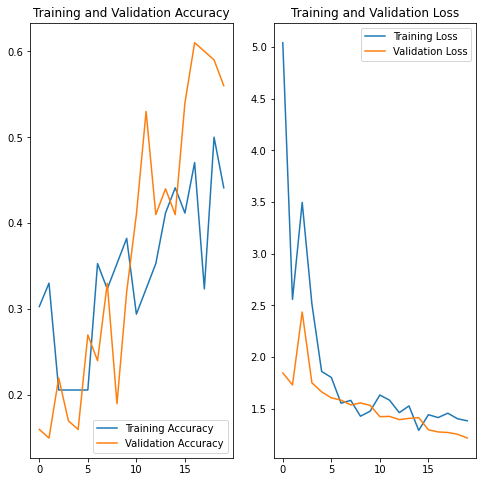

In [ ]:
# plotting the model fit
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##  Experiment 6 : model_6
- ablation approach
- image size = 160,160
- frames = 20
- changing cropping

In [ ]:
## Genearator
x = 20  # number of frames
y = 160 # image width
z = 160 # image height
batch_size = 15
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,13,14,16,18,20,22,24,25,26,27,28,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    ## cropping the image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:160,10:170]
                    else:
                        pass
                    ## resizing image  
                    resized_image = resize(image,(160,160)).astype(np.float32)
                    ## normalising the image
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    ## cropping the image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:160,10:170]
                    else:
                        pass
                    ## resizing image  
                    resized_image = resize(image,(160,160)).astype(np.float32)
                    ## normalising the image
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [ ]:
## Leaner Model ( halving the parameters)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here
# model_6
model_6 = Sequential()

model_6.add(Conv3D(16,kernel_size=(3,3,3), 
                 input_shape=(20, 160, 160, 3),
                 padding='same'))
model_6.add(BatchNormalization())
model_6.add(Activation('relu'))

model_6.add(MaxPooling3D(pool_size=(2,2,2)))

model_6.add(Conv3D(32,kernel_size=(3,3,3), 
                 padding='same'))
model_6.add(BatchNormalization())
model_6.add(Activation('relu'))

model_6.add(MaxPooling3D(pool_size=(2,2,2)))

model_6.add(Conv3D(64,kernel_size=(1,3,3), 
                 padding='same'))
model_6.add(BatchNormalization())
model_6.add(Activation('relu'))

model_6.add(MaxPooling3D(pool_size=(2,2,2)))

model_6.add(Conv3D(128,kernel_size=(1,3,3), 
                 padding='same'))
model_6.add(BatchNormalization())
model_6.add(Activation('relu'))

model_6.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_6.add(Flatten())

model_6.add(Dense(1000, activation='relu'))
model_6.add(Dropout(0.5))

model_6.add(Dense(500, activation='relu'))
model_6.add(Dropout(0.5))

#softmax layer
model_6.add(Dense(5, activation='softmax'))

In [ ]:
## setting optimizer and compiling the model
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model_6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_6.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
batch_normalization_24 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
activation_24 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
max_pooling3d_24 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
batch_normalization_25 (Batc (None, 10, 80, 80, 32)    128       
_________________________________________________________________
activation_25 (Activation)   (None, 10, 80, 80, 32)   

In [ ]:
## picking 200 images each from training and validtion sets
train_generator = generator(train_path, train_doc[0:199], batch_size)
val_generator = generator(val_path, val_doc[0:199], batch_size)

In [ ]:
# saving model name after each epoch
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
### the learning rate after each epoch into the disk with the filepath name
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
## using earlystop
earlystop = tf.keras.callbacks.EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
## training the model
history = model_6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 15
Epoch 1/20
45/45 [==============================] - ETA: 0s - loss: 20.2542 - categorical_accuracy: 0.2229Source path =  /home/datasets/Project_data/val ; batch size = 15
Batch:  7 Index: 15

Epoch 00001: val_loss improved from inf to 46.60106, saving model to model_init_2021-09-0708_44_18.624656/model-00001-20.25415-0.22291-46.60106-0.17000.h5
45/45 [==============================] - 62s 1s/step - loss: 20.2542 - categorical_accuracy: 0.2229 - val_loss: 46.6011 - val_categorical_accuracy: 0.1700
Epoch 2/20
45/45 [==============================] - ETA: 0s - loss: 10.8383 - categorical_accuracy: 0.2941
Epoch 00002: val_loss improved from 46.60106 to 2.53089, saving model to model_init_2021-09-0708_44_18.624656/model-00002-10.83830-0.29412-2.53089-0.42857.h5
45/45 [==============================] - 34s 751ms/step - loss: 10.8383 - categorical_accuracy: 0.2941 - val_loss: 2.5309 - val_categorical_accuracy: 0.4286
Epoch 3/2

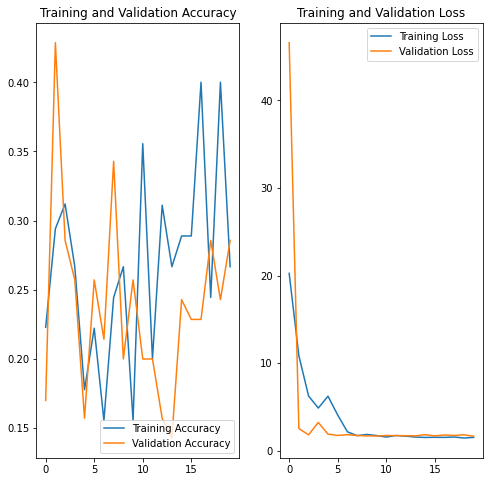

In [ ]:
## plotting
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- Till now we have tested 7 models(including the base model). 
- So far the best model has been model 3 with accuracy in the range of 80% and no overfitting. 
- We also tried to experiment with different versions of this model by modifying the network configurations and also by toying around with image_frames, image size and image cropping.
- Now let's experiment with model 3 in terms of batch size, epochs and probalbly the optimizer

 ## Experiment 7 : model_7
- ablation approach
- using model_3
- increasing batch size to 20
- increasing the number of epochs to 30
- changing the optimizer to SGD

In [ ]:
## Genearator
x = 18  # number of frames
y = 120 # image width
z = 120 # image height
batch_size = 20


def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,23,24,26,28,27,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    ## cropping the image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,10:150]
                    else:
                        pass
                    ## resizing image  
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    ## normalising the image
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    ## cropping the image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,10:150]
                    else:
                        pass
                    ## resizing the image
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    ## normalising the image
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [ ]:
## Leaner Model ( halving the parameters)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

# model_7
model_7 = Sequential()

model_7.add(Conv3D(16,kernel_size=(3,3,3), 
                 input_shape=(18, 120, 120, 3),
                 padding='same'))
model_7.add(BatchNormalization())
model_7.add(Activation('relu'))

model_7.add(MaxPooling3D(pool_size=(2,2,2)))

model_7.add(Conv3D(32,kernel_size=(3,3,3), 
                 padding='same'))
model_7.add(BatchNormalization())
model_7.add(Activation('relu'))

model_7.add(MaxPooling3D(pool_size=(2,2,2)))

model_7.add(Conv3D(64,kernel_size=(1,3,3), 
                 padding='same'))
model_7.add(BatchNormalization())
model_7.add(Activation('relu'))

model_7.add(MaxPooling3D(pool_size=(2,2,2)))

model_7.add(Conv3D(128,kernel_size=(1,3,3), 
                 padding='same'))
model_7.add(BatchNormalization())
model_7.add(Activation('relu'))

model_7.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_7.add(Flatten())

model_7.add(Dense(1000, activation='relu'))
model_7.add(Dropout(0.5))

model_7.add(Dense(500, activation='relu'))
model_7.add(Dropout(0.5))

#softmax layer
model_7.add(Dense(5, activation='softmax'))

In [ ]:
## setting optimizer and compiling the model
optimiser = optimizers.SGD(lr=0.001) #write your optimizer
model_7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_7.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_28 (Conv3D)           (None, 18, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_28 (Batc (None, 18, 120, 120, 16)  64        
_________________________________________________________________
activation_28 (Activation)   (None, 18, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_28 (MaxPooling (None, 9, 60, 60, 16)     0         
_________________________________________________________________
conv3d_29 (Conv3D)           (None, 9, 60, 60, 32)     13856     
_________________________________________________________________
batch_normalization_29 (Batc (None, 9, 60, 60, 32)     128       
_________________________________________________________________
activation_29 (Activation)   (None, 9, 60, 60, 32)    

In [ ]:
## picking 200 images each from training and validtion sets
train_generator = generator(train_path, train_doc[0:199], batch_size)
val_generator = generator(val_path, val_doc[0:199], batch_size)

In [ ]:
## saving model name after each epoch
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
### the learning rate after each epoch into the disk with the filepath name
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
## using earlystop
earlystop = tf.keras.callbacks.EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
## training the model
history = model_7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 2.5510 - categorical_accuracy: 0.2699Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.59963, saving model to model_init_2021-09-0708_53_18.725365/model-00001-2.55098-0.26990-1.59963-0.21000.h5
34/34 [==============================] - 68s 2s/step - loss: 2.5510 - categorical_accuracy: 0.2699 - val_loss: 1.5996 - val_categorical_accuracy: 0.2100
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 2.6629 - categorical_accuracy: 0.2170
Epoch 00002: val_loss did not improve from 1.59963
34/34 [==============================] - 26s 762ms/step - loss: 2.6629 - categorical_accuracy: 0.2170 - val_loss: 1.6868 - val_categorical_accuracy: 0.1700
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 4.0891 - categorical_accuracy: 0.2647
Epoch 00003: val_loss did not improve 

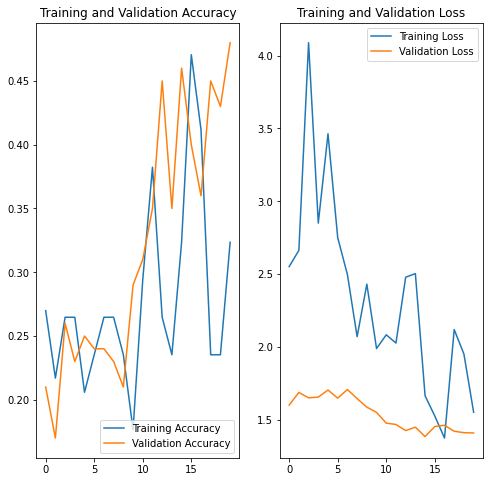

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Experiment 8 : model_8
- ablation approach
- using model_3
- batch_size = 30
- optimizer = SGD

In [ ]:
## Genearator
x = 16  # number of frames
y = 120 # image width
z = 120 # image height
batch_size = 30


def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    ## cropping the image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,10:150]
                    else:
                        pass
                    ## resizing image  
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    ## normalising the image
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    ## cropping the image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,10:150]
                    else:
                        pass
                    ## resizing the image
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    ## normalising the image
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [ ]:
## Leaner Model ( halving the parameters)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers


# model_8
model_8 = Sequential()

model_8.add(Conv3D(16,kernel_size=(3,3,3), 
                 input_shape=(16, 120, 120, 3),
                 padding='same'))
model_8.add(BatchNormalization())
model_8.add(Activation('relu'))

model_8.add(MaxPooling3D(pool_size=(2,2,2)))

model_8.add(Conv3D(32,kernel_size=(3,3,3), 
                 padding='same'))
model_8.add(BatchNormalization())
model_8.add(Activation('relu'))

model_8.add(MaxPooling3D(pool_size=(2,2,2)))

model_8.add(Conv3D(64,kernel_size=(1,3,3), 
                 padding='same'))
model_8.add(BatchNormalization())
model_8.add(Activation('relu'))

model_8.add(MaxPooling3D(pool_size=(2,2,2)))

model_8.add(Conv3D(128,kernel_size=(1,3,3), 
                 padding='same'))
model_8.add(BatchNormalization())
model_8.add(Activation('relu'))

model_8.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_8.add(Flatten())

model_8.add(Dense(1000, activation='relu'))
model_8.add(Dropout(0.5))

model_8.add(Dense(500, activation='relu'))
model_8.add(Dropout(0.5))

#softmax layer
model_8.add(Dense(5, activation='softmax'))

In [ ]:
## setting optimizer and compiling the model
optimiser = optimizers.SGD(lr=0.001) #write your optimizer
model_8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_8.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_32 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_32 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
activation_32 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_32 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_33 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
batch_normalization_33 (Batc (None, 8, 60, 60, 32)     128       
_________________________________________________________________
activation_33 (Activation)   (None, 8, 60, 60, 32)    

In [ ]:
# picking 200 images each from training and validtion sets
train_generator = generator(train_path, train_doc[0:199], batch_size)
val_generator = generator(val_path, val_doc[0:199], batch_size)

In [ ]:
## saving model name after each epoch
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
### the learning rate after each epoch into the disk with the filepath name
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
## using earlystop
earlystop = tf.keras.callbacks.EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
## training the model
history = model_8.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 2.7893 - categorical_accuracy: 0.2235Source path =  /home/datasets/Project_data/val ; batch size = 30
Batch:  4 Index: 30

Epoch 00001: val_loss improved from inf to 1.61540, saving model to model_init_2021-09-0709_01_26.902334/model-00001-2.78930-0.22348-1.61540-0.21000.h5
23/23 [==============================] - 50s 2s/step - loss: 2.7893 - categorical_accuracy: 0.2235 - val_loss: 1.6154 - val_categorical_accuracy: 0.2100
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 2.0697 - categorical_accuracy: 0.3270
Epoch 00002: val_loss did not improve from 1.61540
23/23 [==============================] - 20s 886ms/step - loss: 2.0697 - categorical_accuracy: 0.3270 - val_loss: 1.6582 - val_categorical_accuracy: 0.2500
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 5.3002 - categorical_accuracy: 0.0000e+00
Epoch 00003: v

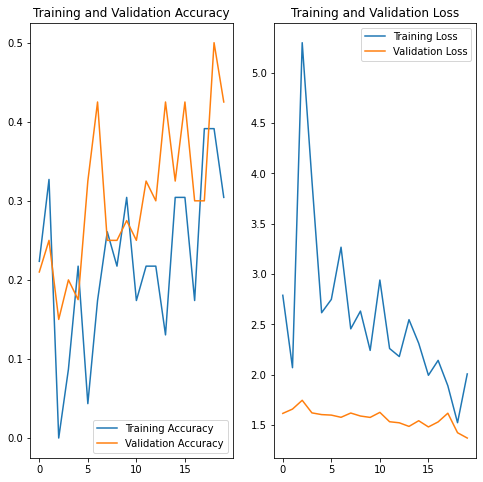

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Experiment 9 : model_9
- ablation approach
- Same as model 3 but with:
- batch size = 40

In [ ]:
## Genearator
x = 16  # number of frames
y = 120 # image width
z = 120 # image height
batch_size = 40

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    ## cropping the image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,10:150]
                    else:
                        pass
                    ## resizing image  
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    ## normalising the image
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    ## cropping the image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,10:150]
                    else:
                        pass
                    ## resizing the image
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    ## normalising the image
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [ ]:
## Leaner Model ( halving the parameters)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

# model_9
model_9 = Sequential()

model_9.add(Conv3D(16,kernel_size=(3,3,3), 
                 input_shape=(16, 120, 120, 3),
                 padding='same'))
model_9.add(BatchNormalization())
model_9.add(Activation('relu'))

model_9.add(MaxPooling3D(pool_size=(2,2,2)))

model_9.add(Conv3D(32,kernel_size=(3,3,3), 
                 padding='same'))
model_9.add(BatchNormalization())
model_9.add(Activation('relu'))

model_9.add(MaxPooling3D(pool_size=(2,2,2)))

model_9.add(Conv3D(64,kernel_size=(1,3,3), 
                 padding='same'))
model_9.add(BatchNormalization())
model_9.add(Activation('relu'))

model_9.add(MaxPooling3D(pool_size=(2,2,2)))

model_9.add(Conv3D(128,kernel_size=(1,3,3), 
                 padding='same'))
model_9.add(BatchNormalization())
model_9.add(Activation('relu'))

model_9.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_9.add(Flatten())

model_9.add(Dense(1000, activation='relu'))
model_9.add(Dropout(0.5))

model_9.add(Dense(500, activation='relu'))
model_9.add(Dropout(0.5))

#softmax layer
model_9.add(Dense(5, activation='softmax'))

In [ ]:
## setting optimizer and compiling the model
optimiser = optimizers.SGD(lr=0.001) #write your optimizer
model_9.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_9.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_36 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_36 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
activation_36 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_36 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_37 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
batch_normalization_37 (Batc (None, 8, 60, 60, 32)     128       
_________________________________________________________________
activation_37 (Activation)   (None, 8, 60, 60, 32)    

In [ ]:
## 200 images each from both the training and the validation sets
train_generator = generator(train_path, train_doc[0:199], batch_size)
val_generator = generator(val_path, val_doc[0:199], batch_size)

In [ ]:
## saving model name after each epoch
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
### the learning rate after each epoch into the disk with the filepath name
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
## using earlystop
earlystop = tf.keras.callbacks.EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
## training the model
history = model_9.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 40
Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 2.7711 - categorical_accuracy: 0.2275Source path =  /home/datasets/Project_data/val ; batch size = 40
Batch:  3 Index: 40

Epoch 00001: val_loss improved from inf to 1.61735, saving model to model_init_2021-09-0709_06_48.873210/model-00001-2.77113-0.22749-1.61735-0.19000.h5
17/17 [==============================] - 48s 3s/step - loss: 2.7711 - categorical_accuracy: 0.2275 - val_loss: 1.6174 - val_categorical_accuracy: 0.1900
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 2.3815 - categorical_accuracy: 0.2500
Epoch 00002: val_loss did not improve from 1.61735
17/17 [==============================] - 14s 816ms/step - loss: 2.3815 - categorical_accuracy: 0.2500 - val_loss: 1.6602 - val_categorical_accuracy: 0.1333
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 1.9376 - categorical_accuracy: 0.3235
Epoch 00003: val_l

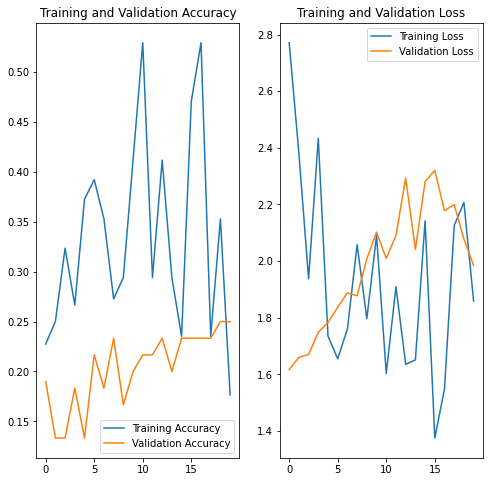

In [ ]:
## plotting
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# RNN + CNN Conv2D Model 

## Vanilla CNN LSTM with GRU 

In [ ]:
## importing libraries
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation,TimeDistributed, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
## Setting the random seed so that the results don't vary drastically
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In [ ]:
## path declerations
## each sequence contains 30 images
## train_doc: list of path of all the training videos
## val_doc: list of path of all the validation videos
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 10 #experiment with the batch size

## Experiment 10: model_10
- ablation appraoch
- Vanilla CNN LSTM with GRU

In [ ]:
x = 20 # number of frames
y = 120 # image width
z = 120 # image height
batch_size = 10

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,5,6,8,9,10,12,14,15,16,18,20,21,22,24,26,28,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.uint8)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.uint8)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # since we just have to see whether the model overfits on small data, using 10 epochs would be sufficient
print ('# epochs =', num_epochs)


# training sequences = 663
# validation sequences = 100
# epochs = 10


In [ ]:
## imporitng librearies
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation,TimeDistributed, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
## model
model_10 = Sequential()

model_10.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(20,120,120,3)))
model_10.add(TimeDistributed(BatchNormalization()))
model_10.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_10.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_10.add(TimeDistributed(BatchNormalization()))
model_10.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_10.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_10.add(TimeDistributed(BatchNormalization()))
model_10.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_10.add(TimeDistributed(Conv2D(512, (3, 3) , padding='same', activation='relu')))
model_10.add(TimeDistributed(BatchNormalization()))
model_10.add(TimeDistributed(MaxPooling2D((2, 2))))
        

model_10.add(TimeDistributed(Flatten()))


model_10.add(GRU(256))
model_10.add(Dropout(.25))
        
model_10.add(Dense(512,activation='relu'))
model_10.add(Dropout(.25))
model_10.add(Dense(1000,activation='relu'))
model_10.add(Dropout(.25))
        
model_10.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.Adam(lr=0.0001)
model_10.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_10.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 120, 120, 64)  1792      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 120, 120, 64)  256       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 60, 60, 64)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 60, 60, 128)   73856     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 60, 60, 128)   512       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 30, 30, 128)   0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 30, 30, 256) 

In [ ]:
## 100 images each from the training and the validation sets
train_generator = generator(train_path, train_doc[0:99], batch_size)
val_generator = generator(val_path, val_doc[0:99], batch_size)

In [ ]:
model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model_10.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 1.0521 - categorical_accuracy: 0.6503Source path =  /home/datasets/Project_data/val ; batch size = 10
Batch:  10 Index: 10

Epoch 00001: val_loss improved from inf to 1.66460, saving model to model_init_conv_lstm_2021-09-0709_13_57.738700/model-00001-1.05206-0.65033-1.66460-0.14141.h5
67/67 [==============================] - 110s 2s/step - loss: 1.0521 - categorical_accuracy: 0.6503 - val_loss: 1.6646 - val_categorical_accuracy: 0.1414
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 0.2475 - categorical_accuracy: 0.9585
Epoch 00002: val_loss improved from 1.66460 to 1.63864, saving model to model_init_conv_lstm_2021-09-0709_13_57.738700/model-00002-0.24747-0.95854-1.63864-0.16667.h5
67/67 [==============================] - 132s 2s/step - loss: 0.2475 - categorical_accuracy: 0.9585 - val_loss: 1.6386 - val_categorical_accuracy: 0.1667

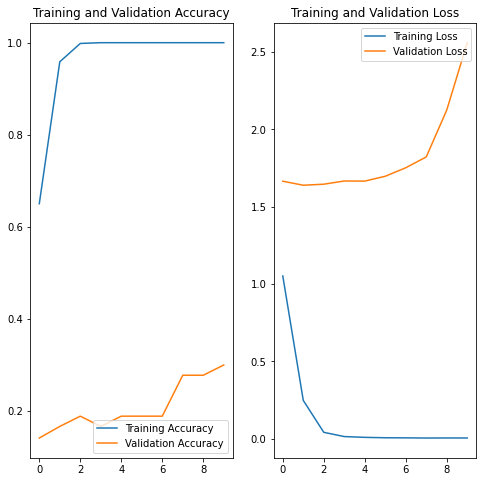

In [ ]:
## plotting
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Experiment 11: model_11
- ablation approach
- reducing the model parameters by one-fourth
- reducing the number of frames to 16
- reducing batch size to 9

In [ ]:
x = 20 # number of frames
y = 120 # image width
z = 120 # image height
batch_size = 9

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,12,14,15,16,18,20,21,22,24,25,26,27,28,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.uint8)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.uint8)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # since we just have to see whether the model overfits on small data, using 10 epochs would be sufficient
print ('# epochs =', num_epochs)


# training sequences = 663
# validation sequences = 100
# epochs = 20


In [ ]:
model_11 = Sequential()

model_11.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(20,120,120,3)))
model_11.add(TimeDistributed(BatchNormalization()))
model_11.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_11.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_11.add(TimeDistributed(BatchNormalization()))
model_11.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_11.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_11.add(TimeDistributed(BatchNormalization()))
model_11.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_11.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_11.add(TimeDistributed(BatchNormalization()))
model_11.add(TimeDistributed(MaxPooling2D((2, 2))))
        

model_11.add(TimeDistributed(Flatten()))


model_11.add(GRU(64))
model_11.add(Dropout(.25))
        
model_11.add(Dense(64,activation='relu'))
model_11.add(Dropout(.25))
model_11.add(Dense(128,activation='relu'))
model_11.add(Dropout(.25))
        
model_11.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.Adam(lr=0.0001)
model_11.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_11.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_13 (TimeDis (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_14 (TimeDis (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_15 (TimeDis (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_17 (TimeDis (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_18 (TimeDis (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 20, 30, 30, 64)  

In [ ]:
## 200 images each from the training and the validation sets
train_generator = generator(train_path, train_doc[0:199], batch_size)
val_generator = generator(val_path, val_doc[0:199], batch_size)

In [ ]:
history = model_11.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.6280 - categorical_accuracy: 0.2638Source path =  /home/datasets/Project_data/val ; batch size = 9

Epoch 00001: val_loss improved from 1.63864 to 1.63200, saving model to model_init_conv_lstm_2021-09-0709_13_57.738700/model-00001-1.62796-0.26380-1.63200-0.22222.h5
67/67 [==============================] - 59s 882ms/step - loss: 1.6280 - categorical_accuracy: 0.2638 - val_loss: 1.6320 - val_categorical_accuracy: 0.2222
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.6006 - categorical_accuracy: 0.2836Batch:  12 Index: 9

Epoch 00002: val_loss did not improve from 1.63200
67/67 [==============================] - 19s 280ms/step - loss: 1.6006 - categorical_accuracy: 0.2836 - val_loss: 1.6422 - val_categorical_accuracy: 0.2000
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.5637 - categorical_accuracy: 0.2836
Epoch 00003: val_loss did not improve from 1.63200

Epoch 00003: Redu

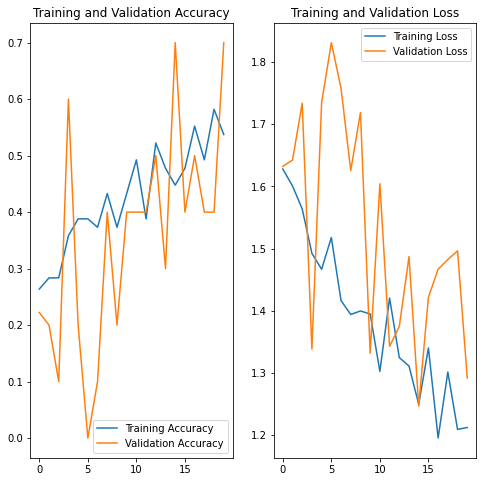

In [ ]:
## plotting
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Experiment 12 : model_12
- ablation approach
- increasing model parameters
- reducing the frames to 16
- increasing batch size to 15

In [ ]:
x = 16 # number of frames
y = 120 # image width
z = 120 # image height
batch_size = 15

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.uint8)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.uint8)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [ ]:
model_12 = Sequential()

model_12.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(16,120,120,3)))
model_12.add(TimeDistributed(BatchNormalization()))
model_12.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_12.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_12.add(TimeDistributed(BatchNormalization()))
model_12.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_12.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_12.add(TimeDistributed(BatchNormalization()))
model_12.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_12.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_12.add(TimeDistributed(BatchNormalization()))
model_12.add(TimeDistributed(MaxPooling2D((2, 2))))
        

model_12.add(TimeDistributed(Flatten()))


model_12.add(GRU(32))
model_12.add(Dropout(.25))
        
model_12.add(Dense(128,activation='relu'))
model_12.add(Dropout(.25))
model_12.add(Dense(256,activation='relu'))
model_12.add(Dropout(.25))
        
model_12.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.Adam(lr=0.0001)
model_12.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_12.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_39 (TimeDis (None, 16, 120, 120, 32)  896       
_________________________________________________________________
time_distributed_40 (TimeDis (None, 16, 120, 120, 32)  128       
_________________________________________________________________
time_distributed_41 (TimeDis (None, 16, 60, 60, 32)    0         
_________________________________________________________________
time_distributed_42 (TimeDis (None, 16, 60, 60, 64)    18496     
_________________________________________________________________
time_distributed_43 (TimeDis (None, 16, 60, 60, 64)    256       
_________________________________________________________________
time_distributed_44 (TimeDis (None, 16, 30, 30, 64)    0         
_________________________________________________________________
time_distributed_45 (TimeDis (None, 16, 30, 30, 128) 

In [ ]:
## 200 images each from the training and the validation sets
train_generator = generator(train_path, train_doc[0:199], batch_size)
val_generator = generator(val_path, val_doc[0:199], batch_size)

In [ ]:
history = model_12.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.5969 - categorical_accuracy: 0.2454Source path =  /home/datasets/Project_data/val ; batch size = 15
Batch:  7 Index: 15

Epoch 00001: val_loss did not improve from 1.24674
67/67 [==============================] - 89s 1s/step - loss: 1.5969 - categorical_accuracy: 0.2454 - val_loss: 1.6172 - val_categorical_accuracy: 0.2462
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.5329 - categorical_accuracy: 0.3228
Epoch 00002: val_loss did not improve from 1.24674
67/67 [==============================] - 51s 755ms/step - loss: 1.5329 - categorical_accuracy: 0.3228 - val_loss: 1.6237 - val_categorical_accuracy: 0.1900
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.4827 - categorical_accuracy: 0.4030
Epoch 00003: val_loss did not improve from 1.24674
67/67 [==============================] - 31s 460ms/step - loss: 1.4827 - categorical_accuracy: 0.4030 - val_loss: 1.6014 - val_categori

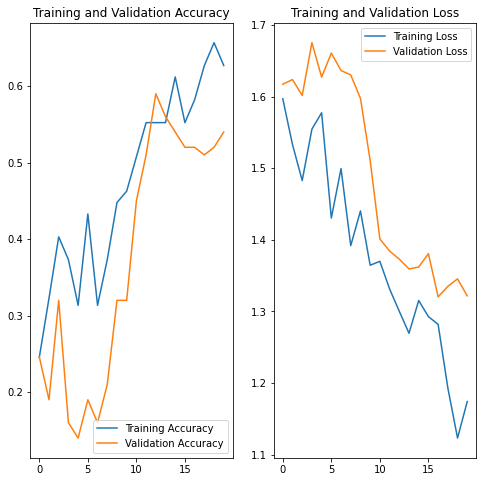

In [ ]:
## plotting
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Transfer Learning

## Experiment 13 : model_13
- VGG16 wihtb GRU
- batch_size=9


In [ ]:
x = 16 # number of frames
y = 120 # image width
z = 120 # image height
batch_size = 9

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((9,16,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.uint8)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((9,16,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.uint8)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels
            

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
## model
from tensorflow.keras.applications.vgg16 import VGG16
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)
features = Dense(256, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model_13 = Sequential()
model_13.add(TimeDistributed(conv_model, input_shape=(16,120,120,3)))
model_13.add(GRU(64, return_sequences=True))
model_13.add(GRU(32))
model_13.add(Dropout(0.5))
model_13.add(Dense(256, activation='relu'))
model_13.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.Adam(lr=0.0001)
model_13.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_13.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 16, 256)           15894592  
_________________________________________________________________
gru (GRU)                    (None, 16, 64)            61824     
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8448      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 15,975,557
Trainable params: 1,260,869
Non-trainable params: 14,714,688
____________________________________

In [ ]:
## 200 images each from the training and the validation sets
train_generator = generator(train_path, train_doc[0:199], batch_size)
val_generator = generator(val_path, val_doc[0:199], batch_size)

In [ ]:
model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model_13.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
Source path =  /home/datasets/Project_data/train ; batch size = 9
Epoch 1/20
74/74 [==============================] - ETA: 0s - loss: 1.6251 - categorical_accuracy: 0.1847Source path =  /home/datasets/Project_data/val ; batch size = 9
Batch:  12 Index: 9

Epoch 00001: val_loss improved from inf to 1.61116, saving model to model_init_conv_lstm_2021-09-0713_04_25.984491/model-00001-1.62507-0.18468-1.61116-0.21296.h5
74/74 [==============================] - 50s 672ms/step - loss: 1.6251 - categorical_accuracy: 0.1847 - val_loss: 1.6112 - val_categorical_accuracy: 0.2130
Epoch 2/20
74/74 [==============================] - ETA: 0s - loss: 1.6396 - categorical_accuracy: 0.2057
Epoch 00002: val_loss did not improve from 1.61116
74/74 [==============================] - 15s 206ms/step - loss: 1.6396 - categorical_accuracy: 0.2057 - val_loss: 1.6427 - val_categorical_accuracy: 0.1667
Epoch 3/20
74/74 [===================

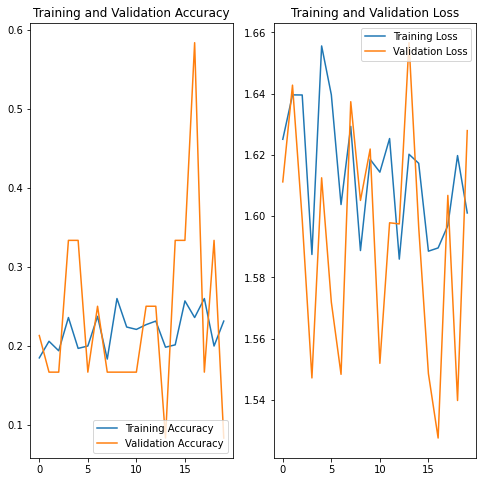

In [ ]:
## plotting
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Experiment 14 : model_14
- VGGNet with GRU
- number of frames = 20
- batch_size = 20

In [ ]:
## generator
x = 30 # number of frames
y = 120 # image width
z = 120 # image height
batch_size = 9

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,30)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((9,30,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.uint8)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,10:150]
                    else:
                        pass
                    
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((9,30,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.uint8)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,10:150]
                    else:
                        pass
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [ ]:
## model
from tensorflow.keras.applications.vgg16 import VGG16
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)
features = Dense(256, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model_14 = Sequential()
model_14.add(TimeDistributed(conv_model, input_shape=(30,120,120,3)))
model_14.add(GRU(64, return_sequences=True))
model_14.add(GRU(32))
model_14.add(Dropout(0.5))
model_14.add(Dense(256, activation='relu'))
model_14.add(Dense(5, activation='softmax'))

In [ ]:
## optiomizer and compile
optimiser = optimizers.Adam(lr=0.0001)
model_14.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_14.summary())

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_28 (TimeDis (None, 30, 256)           15894592  
_________________________________________________________________
gru_56 (GRU)                 (None, 30, 64)            61824     
_________________________________________________________________
gru_57 (GRU)                 (None, 32)                9408      
_________________________________________________________________
dropout_28 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_85 (Dense)             (None, 256)               8448      
_________________________________________________________________
dense_86 (Dense)             (None, 5)                 1285      
Total params: 15,975,557
Trainable params: 1,260,869
Non-trainable params: 14,714,688
_________________________________

In [ ]:
## picking 200 images each from training and validtion sets
train_generator = generator(train_path, train_doc[0:199], batch_size)
val_generator = generator(val_path, val_doc[0:199], batch_size)

In [ ]:
## saving model name after each epoch
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
### the learning rate after each epoch into the disk with the filepath name
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model_14.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 9
Epoch 1/20
74/74 [==============================] - ETA: 0s - loss: 1.6236 - categorical_accuracy: 0.2027Source path =  /home/datasets/Project_data/val ; batch size = 9
Batch:  12 Index: 9

Epoch 00001: val_loss improved from inf to 1.63600, saving model to model_init_2021-09-0715_25_27.639089/model-00001-1.62355-0.20270-1.63600-0.19444.h5
74/74 [==============================] - 82s 1s/step - loss: 1.6236 - categorical_accuracy: 0.2027 - val_loss: 1.6360 - val_categorical_accuracy: 0.1944
Epoch 2/20
74/74 [==============================] - ETA: 0s - loss: 1.6398 - categorical_accuracy: 0.1787
Epoch 00002: val_loss improved from 1.63600 to 1.56773, saving model to model_init_2021-09-0715_25_27.639089/model-00002-1.63979-0.17868-1.56773-0.25000.h5
74/74 [==============================] - 25s 343ms/step - loss: 1.6398 - categorical_accuracy: 0.1787 - val_loss: 1.5677 - val_categorical_accuracy: 0.2500
Epoch 3/20
74/74 [===

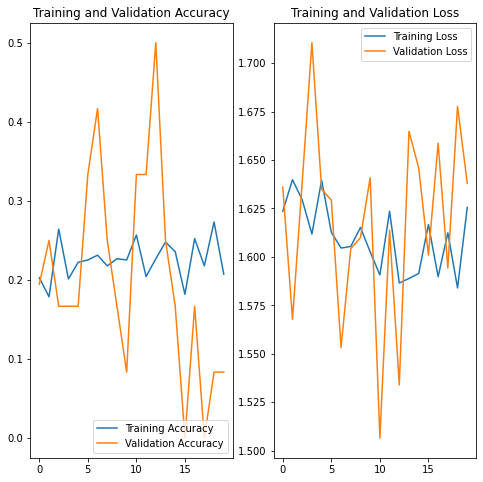

In [ ]:
## plotting
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# MobileNet with GRU

## Experiment 16 : model_16
- ablation approach
- image size = 128 X 128
- using cropping

In [ ]:
## Genearator
x = 16  # number of frames
y = 128 # image width
z = 128 # image height
batch_size = 9

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = img_idx = [0,2,6,8,10,12,14,16,18,20,22,24,26,27,28,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((9,16,128,128,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    ## cropping the image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,10:150]
                    else:
                        pass
                    ## resizing image  
                    resized_image = resize(image,(128,128)).astype(np.float32)
                    ## normalising the image
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((9,16,128,128,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    ## cropping the image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,10:150]
                    else:
                        pass
                    ## resizing the image
                    resized_image = resize(image,(128,128)).astype(np.float32)
                    ## normalising the image
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
base_model = MobileNet(input_shape=(128,128,3), weights='imagenet', include_top=False)
x = base_model.output
x = Flatten()(x)
features = Dense(256, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model_16 = Sequential()
model_16.add(TimeDistributed(conv_model, input_shape=(16,128,128,3)))
model_16.add(GRU(64, return_sequences=True))
model_16.add(GRU(32))
model_16.add(Dropout(0.5))
model_16.add(Dense(256, activation='relu'))
model_16.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.Adam(lr=0.0001)
model_16.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_16.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 16, 256)           7423424   
_________________________________________________________________
gru_4 (GRU)                  (None, 16, 64)            61824     
_________________________________________________________________
gru_5 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               8448      
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 1285      
Total params: 7,504,389
Trainable params: 4,275,525
Non-trainable params: 3,228,864
____________________________________

In [ ]:
## 200 images eacgh from the trainign and the validation sets 
train_generator = generator(train_path, train_doc[0:199], batch_size)
val_generator = generator(val_path, val_doc[0:199], batch_size)

In [ ]:
model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model_16.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 9
Epoch 1/20
74/74 [==============================] - ETA: 0s - loss: 1.6250 - categorical_accuracy: 0.2673Source path =  /home/datasets/Project_data/val ; batch size = 9
Batch:  12 Index: 9

Epoch 00001: val_loss improved from inf to 1.48952, saving model to model_init_conv_lstm_2021-09-0713_35_11.486837/model-00001-1.62496-0.26727-1.48952-0.37963.h5
74/74 [==============================] - 43s 579ms/step - loss: 1.6250 - categorical_accuracy: 0.2673 - val_loss: 1.4895 - val_categorical_accuracy: 0.3796
Epoch 2/20
74/74 [==============================] - ETA: 0s - loss: 1.6406 - categorical_accuracy: 0.2297
Epoch 00002: val_loss did not improve from 1.48952
74/74 [==============================] - 14s 186ms/step - loss: 1.6406 - categorical_accuracy: 0.2297 - val_loss: 1.4981 - val_categorical_accuracy: 0.5833
Epoch 3/20
74/74 [==============================] - ETA: 0s - loss: 1.6063 - categorical_accuracy: 0.2372
Epoch 0

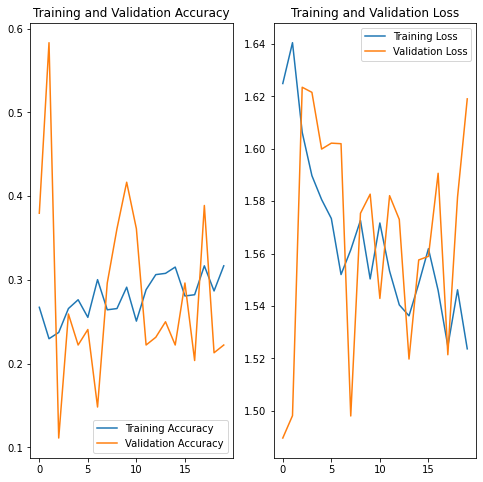

In [ ]:
## plotting
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Experiment 17 : model_17
- changing the batch size
- reducing the number of frames

In [ ]:
## Genearator
x = 10  # number of frames
y = 128 # image width
z = 128 # image height
batch_size = 15

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = img_idx = [0,2,8,12,18,21,24,26,28,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((15,10,128,128,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((15,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    ## cropping the image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,10:150]
                    else:
                        pass
                    ## resizing image  
                    resized_image = resize(image,(128,128)).astype(np.float32)
                    ## normalising the image
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((15,10,128,128,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((15,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    ## cropping the image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,10:150]
                    else:
                        pass
                    ## resizing the image
                    resized_image = resize(image,(128,128)).astype(np.float32)
                    ## normalising the image
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
base_model = MobileNet(input_shape=(128,128,3), weights='imagenet', include_top=False)
x = base_model.output
x = Flatten()(x)
features = Dense(256, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model_17 = Sequential()
model_17.add(TimeDistributed(conv_model, input_shape=(10,128,128,3)))
model_17.add(GRU(64, return_sequences=True))
model_17.add(GRU(32))
model_17.add(Dropout(0.5))
model_17.add(Dense(256, activation='relu'))
model_17.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.Adam(lr=0.0001)
model_17.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_17.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 10, 256)           7423424   
_________________________________________________________________
gru_8 (GRU)                  (None, 10, 64)            61824     
_________________________________________________________________
gru_9 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               8448      
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 1285      
Total params: 7,504,389
Trainable params: 4,275,525
Non-trainable params: 3,228,864
____________________________________

In [ ]:
## 200 images eacgh from the trainign and the validation sets 
train_generator = generator(train_path, train_doc[0:199], batch_size)
val_generator = generator(val_path, val_doc[0:199], batch_size)

In [ ]:
history = model_17.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 15
Epoch 1/20
74/74 [==============================] - ETA: 0s - loss: 0.5786 - categorical_accuracy: 0.4072Source path =  /home/datasets/Project_data/val ; batch size = 15
Batch:  7 Index: 15

Epoch 00001: val_loss improved from 1.48952 to 1.14502, saving model to model_init_conv_lstm_2021-09-0713_35_11.486837/model-00001-0.57863-0.40721-1.14502-0.68333.h5
74/74 [==============================] - 44s 590ms/step - loss: 0.5786 - categorical_accuracy: 0.4072 - val_loss: 1.1450 - val_categorical_accuracy: 0.6833
Epoch 2/20
74/74 [==============================] - ETA: 0s - loss: 0.2087 - categorical_accuracy: 0.4901
Epoch 00002: val_loss improved from 1.14502 to 0.85152, saving model to model_init_conv_lstm_2021-09-0713_35_11.486837/model-00002-0.20873-0.49009-0.85152-0.41111.h5
74/74 [==============================] - 27s 359ms/step - loss: 0.2087 - categorical_accuracy: 0.4901 - val_loss: 0.8515 - val_categorical_accuracy:

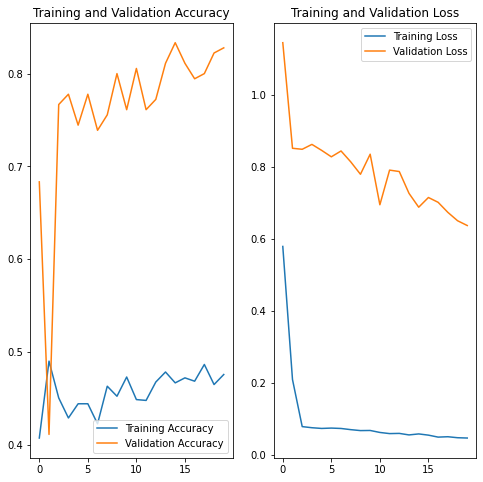

In [ ]:
## plotting
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Experiment 18 : model_18
- keeping the number of frames to 10
- changing the image size
- reducing the batch size

In [ ]:
## Genearator
x = 10  # number of frames
y = 120 # image width
z = 120 # image height
batch_size = 9

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = img_idx = [0,2,8,12,18,21,24,26,28,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((9,10,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    ## cropping the image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,10:150]
                    else:
                        pass
                    ## resizing image  
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    ## normalising the image
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((9,10,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    ## cropping the image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,10:150]
                    else:
                        pass
                    ## resizing the image
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    ## normalising the image
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
base_model = MobileNet(input_shape=(120,120,3), weights='imagenet', include_top=False)
x = base_model.output
x = Flatten()(x)
features = Dense(256, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model_18 = Sequential()
model_18.add(TimeDistributed(conv_model, input_shape=(10,120,120,3)))
model_18.add(GRU(64, return_sequences=True))
model_18.add(GRU(32))
model_18.add(Dropout(0.5))
model_18.add(Dense(256, activation='relu'))
model_18.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.Adam(lr=0.0001)
model_18.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_18.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 10, 256)           5588416   
_________________________________________________________________
gru_10 (GRU)                 (None, 10, 64)            61824     
_________________________________________________________________
gru_11 (GRU)                 (None, 32)                9408      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               8448      
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 1285      
Total params: 5,669,381
Trainable params: 2,440,517
Non-trainable params: 3,228,864
____________________________________

In [ ]:
## 200 images eacgh from the training and the validation sets 
train_generator = generator(train_path, train_doc[0:199], batch_size)
val_generator = generator(val_path, val_doc[0:199], batch_size)

In [ ]:
history = model_18.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 9
Epoch 1/20
74/74 [==============================] - ETA: 0s - loss: 1.5760 - categorical_accuracy: 0.2763Source path =  /home/datasets/Project_data/val ; batch size = 9
Batch:  12 Index: 9

Epoch 00001: val_loss did not improve from 0.63678
74/74 [==============================] - 26s 352ms/step - loss: 1.5760 - categorical_accuracy: 0.2763 - val_loss: 1.4438 - val_categorical_accuracy: 0.4630
Epoch 2/20
74/74 [==============================] - ETA: 0s - loss: 1.6061 - categorical_accuracy: 0.2387
Epoch 00002: val_loss did not improve from 0.63678
74/74 [==============================] - 9s 123ms/step - loss: 1.6061 - categorical_accuracy: 0.2387 - val_loss: 1.6273 - val_categorical_accuracy: 0.2037
Epoch 3/20
74/74 [==============================] - ETA: 0s - loss: 1.6052 - categorical_accuracy: 0.2553
Epoch 00003: val_loss did not improve from 0.63678

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.99999987

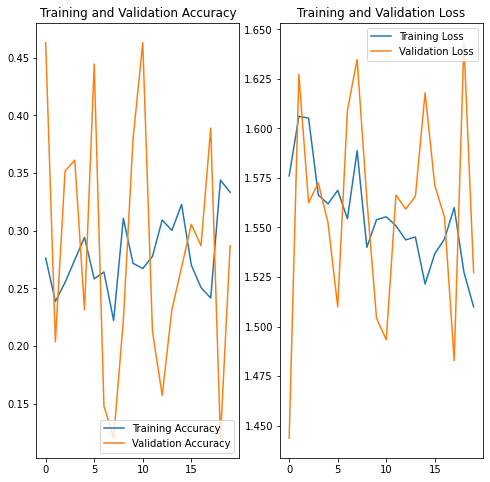

In [ ]:
## plotting
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# ResNet with GRU

## Experiment 19: model_19

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
## Genearator
x = 18  # number of frames
y = 120 # image width
z = 120 # image height
batch_size=2

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = img_idx = [0,2,6,8,10,12,14,16,18,20,22,23,24,25,26,27,28,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((2,18,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    ## cropping the image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,10:150]
                    else:
                        pass
                    ## resizing image  
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    ## normalising the image
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((2,18,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    ## cropping the image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,10:150]
                    else:
                        pass
                    ## resizing the image
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    ## normalising the image
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
base_model = ResNet50(input_shape=(120,120,3), weights='imagenet', include_top=False)
x = base_model.output
x = Flatten()(x)
features = Dense(256, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model_19 = Sequential()
model_19.add(TimeDistributed(conv_model, input_shape=(18,120,120,3)))
model_19.add(GRU(64, return_sequences=True))
model_19.add(GRU(32))
model_19.add(Dropout(0.5))
model_19.add(Dense(256, activation='relu'))
model_19.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.SGD(lr=0.001)
model_19.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_19.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, 18, 256)           31976576  
_________________________________________________________________
gru_6 (GRU)                  (None, 18, 64)            61824     
_________________________________________________________________
gru_7 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               8448      
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 1285      
Total params: 32,057,541
Trainable params: 8,469,829
Non-trainable params: 23,587,712
__________________________________

In [ ]:
## 300 images each from the training and the validation sets
train_generator = generator(train_path, train_doc[0:299], batch_size)
val_generator = generator(val_path, val_doc[0:299], batch_size)

In [ ]:
model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model_19.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 2
Epoch 1/20
332/332 [==============================] - ETA: 0s - loss: 1.6235 - categorical_accuracy: 0.2289Source path =  /home/datasets/Project_data/val ; batch size = 2

Epoch 00001: val_loss improved from inf to 1.61402, saving model to model_init_conv_lstm_2021-09-0714_10_29.095202/model-00001-1.62346-0.22892-1.61402-0.21000.h5
332/332 [==============================] - 78s 234ms/step - loss: 1.6235 - categorical_accuracy: 0.2289 - val_loss: 1.6140 - val_categorical_accuracy: 0.2100
Epoch 2/20
332/332 [==============================] - ETA: 0s - loss: 1.6257 - categorical_accuracy: 0.2214
Epoch 00002: val_loss improved from 1.61402 to 1.59608, saving model to model_init_conv_lstm_2021-09-0714_10_29.095202/model-00002-1.62573-0.22139-1.59608-0.24000.h5
332/332 [==============================] - 62s 186ms/step - loss: 1.6257 - categorical_accuracy: 0.2214 - val_loss: 1.5961 - val_categorical_accuracy: 0.2400
Epoch 3/20

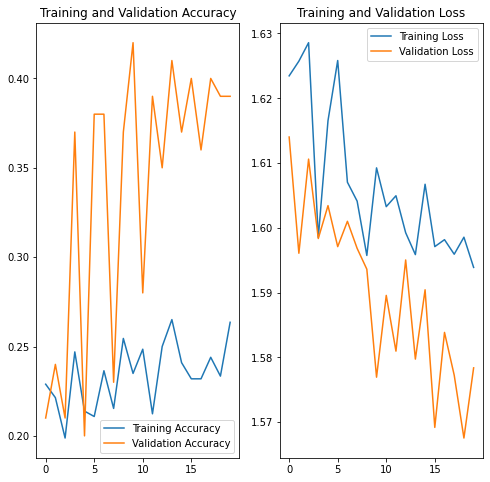

In [ ]:
## plotting
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Experiment 20: model_20
- changing batch_size
- changing the frames

In [ ]:
## Genearator
x = 18  # number of frames
y = 120 # image width
z = 120 # image height
batch_size = 16

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = img_idx = [0,2,6,8,10,12,14,16,18,20,22,23,24,25,26,27,28,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    ## cropping the image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,10:150]
                    else:
                        pass
                    ## resizing image  
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    ## normalising the image
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    ## cropping the image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,10:150]
                    else:
                        pass
                    ## resizing the image
                    resized_image = resize(image,(120,120)).astype(np.float32)
                    ## normalising the image
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
base_model = ResNet50(input_shape=(120,120,3), weights='imagenet', include_top=False)
x = base_model.output
x = Flatten()(x)
features = Dense(256, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model_20 = Sequential()
model_20.add(TimeDistributed(conv_model, input_shape=(18,120,120,3)))
model_20.add(GRU(64, return_sequences=True))
model_20.add(GRU(32))
model_20.add(Dropout(0.5))
model_20.add(Dense(256, activation='relu'))
model_20.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.Adam(lr=0.0001)
model_20.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_20.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_9 (TimeDist (None, 18, 256)           31976576  
_________________________________________________________________
gru_18 (GRU)                 (None, 18, 64)            61824     
_________________________________________________________________
gru_19 (GRU)                 (None, 32)                9408      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 256)               8448      
_________________________________________________________________
dense_29 (Dense)             (None, 5)                 1285      
Total params: 32,057,541
Trainable params: 8,469,829
Non-trainable params: 23,587,712
__________________________________

In [ ]:
history = model_20.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
332/332 [==============================] - ETA: 0s - loss: 1.6406 - categorical_accuracy: 0.2349
Epoch 00001: val_loss did not improve from 1.56756
332/332 [==============================] - 62s 188ms/step - loss: 1.6406 - categorical_accuracy: 0.2349 - val_loss: 1.5943 - val_categorical_accuracy: 0.2900
Epoch 2/20
332/332 [==============================] - ETA: 0s - loss: 1.6579 - categorical_accuracy: 0.1837
Epoch 00002: val_loss did not improve from 1.56756
332/332 [==============================] - 59s 177ms/step - loss: 1.6579 - categorical_accuracy: 0.1837 - val_loss: 1.6026 - val_categorical_accuracy: 0.3200
Epoch 3/20
332/332 [==============================] - ETA: 0s - loss: 1.6319 - categorical_accuracy: 0.2108
Epoch 00003: val_loss did not improve from 1.56756
332/332 [==============================] - 61s 184ms/step - loss: 1.6319 - categorical_accuracy: 0.2108 - val_loss: 1.5929 - val_categorical_accuracy: 0.2500
Epoch 4/20
332/332 [=============================

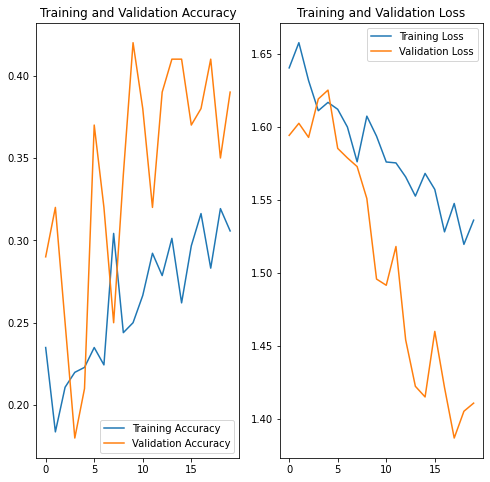

In [ ]:
## plotting
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# The best Model
- After 20 oodd experiments, the best model so was was model 3 